<a href="https://www.kaggle.com/code/somewhatjustin/titanic?scriptVersionId=164563951" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
'''
TODO: 
- check out GridSearchCV
- utilize titles (Miss, Dr, Rev, etc)
'''

'\nTODO: \n- check out GridSearchCV\n- utilize titles (Miss, Dr, Rev, etc)\n'

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
# Combine parch and sibsp into fam
train_data['fam'] = train_data['Parch']+train_data['SibSp']
test_data['fam'] = test_data['Parch']+test_data['SibSp']

def isAlone(fam):
    if fam == 0:
        return True
    else:
        return False

# Check if alone
train_data['alone'] = train_data['fam'].apply(isAlone)
test_data['alone'] = test_data['fam'].apply(isAlone)

In [5]:
# Bucket Age

# Fill NaNs without using inplace=True
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].mean())

# Create age buckets
age_buckets = np.linspace(0,80,20)
train_data['Age_bucket'] = pd.cut(train_data['Age'], age_buckets)
test_data['Age_bucket'] = pd.cut(test_data['Age'], age_buckets)

buckets, blah = pd.factorize(train_data['Age_bucket'])
train_data['Age_bucket'] = buckets
buckets, blah = pd.factorize(test_data['Age_bucket'])
test_data['Age_bucket'] = buckets

#train_data['Age_normalized'] = scaler.fit_transform(train_data[['Age']].values.reshape(-1, 1))
#test_data['Age_normalized'] = scaler.transform(test_data[['Age']].values.reshape(-1, 1))

train_data.head()

# Note: Use scaler.fit_transform() on the training data to fit the scaler and transform the data.
# Use scaler.transform() on the test data to apply the same scaling based on the training data.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fam,alone,Age_bucket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,False,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,False,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,True,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,False,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,True,3


In [6]:
# Fare Normalization
#fareScaler = MinMaxScaler(feature_range=(0,1))

# Fill NaNs without using inplace=True
train_data['Fare'] = train_data['Fare'].fillna(train_data['Fare'].median())
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())

# Fit and transform the data for training and testing
#train_data['Fare'] = fareScaler.fit_transform(train_data[['Fare']].values.reshape(-1,1))
#test_data['Fare'] = fareScaler.transform(test_data[['Fare']].values.reshape(-1,1))

In [7]:
# Passenger Class Normalization

#class_mapping = {1: "First", 2: "Second", 3: "Third"}
#train_data['Pclass'] = train_data['Pclass'].map(class_mapping)
#test_data['Pclass'] = test_data['Pclass'].map(class_mapping)

In [8]:
# Make sex binary

# 0: female
# 1: male

sex_mapping = {"male": 1, "female": 2}
train_data['Sex'] = train_data['Sex'].map(sex_mapping)
test_data['Sex'] = test_data['Sex'].map(sex_mapping)

In [9]:
# Cabin Classifier

def cabin_category(cabin):
    # Check for missing cabin information
    if pd.isnull(cabin):
        return 'Other'
    else:
        # Search for specific letters in the cabin string
        for letter in ['A', 'B', 'C', 'D', 'E', 'F']:
            if letter in cabin:
                return letter
        # Return 'Other' if none of the specific letters are found
        return 'Other'

# Apply the function to create a new 'Cabin_Category' column
train_data['Cabin_Category'] = train_data['Cabin'].apply(cabin_category)
test_data['Cabin_Category'] = test_data['Cabin'].apply(cabin_category)

In [10]:
# Analysis

# Now create a pivot table with the new 'Cabin_Category'
pivot_table = pd.crosstab(index=train_data['Survived'], columns=train_data['Cabin_Category'])

# Display the pivot table
print(pivot_table)

Cabin_Category  A   B   C   D   E  F  Other
Survived                                   
0               8  12  24   8   8  5    484
1               7  35  35  25  25  7    208


In [11]:
y = train_data["Survived"]

features = ["Pclass", "Sex", "Age_bucket", "Fare", "alone", "Embarked", "fam", "Cabin_Category"]
#features = ["Pclass", "Sex", "SibSp", "Parch", "Age_normalized", "Fare"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

#model = GradientBoostingClassifier(n_estimators=150, max_depth=3).fit(X, y)
model = RandomForestClassifier(n_estimators=500).fit(X,y)
submissionPredictions = model.predict(X_test)

In [12]:
# CHECK FOR OVERFITTING
from sklearn.metrics import accuracy_score

training_predictions = model.predict(X)
training_truth = y.to_numpy()

accuracy = accuracy_score(training_truth, training_predictions)
print(f"Accuracy:{accuracy}")

Accuracy:0.9696969696969697


In [13]:
# CROSS-VALIDATION

def splitIntoGroups(data, numGroups):
    df_shuffled = data.sample(frac=1).reset_index(drop=True)
    groups = np.array_split(df_shuffled, 5)
    return groups

def singleHyperTrain(train, test):
    topAccuracy = {"accuracy": 0}
    optimalWeights = []
    estimators = [100, 200, 300, 500, 700, 1000]
    #max_depth = [3, 4, 5,]
    for i in estimators:
        #for j in max_depth:
        y = train["Survived"]
        y_test = test["Survived"]
        # features = ["Pclass", "Sex", "SibSp", "Parch", "Age_normalized", "Embarked", "Fare", "hasAge", "Cabin_Category"]
        features = ["Pclass", "Sex", "Age_bucket", "Fare", "alone", "Embarked", "fam", "Cabin_Category"]
        X = pd.get_dummies(train[features])
        X_test = pd.get_dummies(test[features])
        testModel = RandomForestClassifier(n_estimators=i).fit(X, y)
        predictions = testModel.predict(X_test)
        accuracy = accuracy_score(y_test.to_numpy(), predictions)
        if accuracy > topAccuracy["accuracy"]:
            topAccuracy = {"accuracy": accuracy, "estimators": i}
        print(f"{accuracy} with est: {i}")

    print(f"top accuracy: {topAccuracy['accuracy']} with estimators = {topAccuracy['estimators']}")

def crossTrain(data):
    for i in range(0, len(data)):
        trainGroup = pd.concat([groupsOfData[j] for j in range(len(groupsOfData)) if j != i])
        singleHyperTrain(trainGroup, groupsOfData[i])

groupsOfData = splitIntoGroups(train_data, 5)

# Uncomment to do crosstraining
#crossTrain(groupsOfData)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


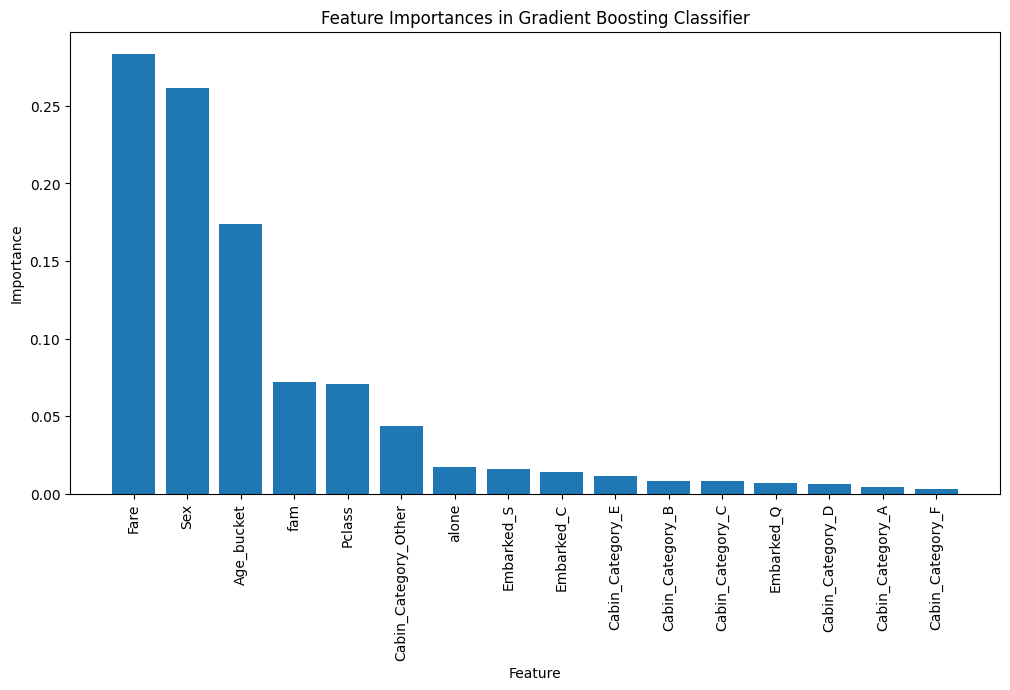

In [14]:
import matplotlib.pyplot as plt

# Accessing feature importances
feature_importances = model.feature_importances_

# Visualizing feature importances
features = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Gradient Boosting Classifier")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [15]:
# CREATE PREDICTIONS
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': submissionPredictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
